# MovieLens Dataset Analysis
Matthew Johnson


The Dataset contained 4 csv files regarding movie ratings.  I want to explore:
1. What genres are most correlated in rating trends or distributions?
2. User rating habits (high/low variance, high/low tendency).
3. Tags associated with positive ratings vs negative ratings.
4. Is there any relationship with Budget/Duration with ratings?

DataFrame shapes:
movies: (9125, 3), ratings: (100004, 4), tags: (1296, 3), links: (9125, 3)



In [549]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

movies_2 = pd.read_csv('movies_exploded.csv')
imdb_usd = pd.read_csv('imdb_usd.csv')
imdb_dat = pd.read_csv('imdb_dat.csv')
imdb_df = pd.read_csv('imdb_scraps.csv')

# Convert genres to one hot encoding
df = pd.merge(movies, ratings)
mdf = pd.concat([df.drop('genres', axis=1), df.genres.str.get_dummies(sep='|')], axis=1)  

#get unique genres as 
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])

In [550]:
exp_df = movies_2[['userId', 'movieId', 'rating', 'year', 'title', 'genres', 'year_made']]

movies_3 = movies_2.loc[movies_2['genres'].isin(
    ['Sci-Fi', 'Action', 'Drama', 'Animation', 'Children','Comedy', 'Romance', 
     'Thriller', 'Horror',  'Crime', 'Adventure'])]

mean_ratings = movies_3.groupby([ 'genres', 'year_made'], 
                               as_index=False)['rating'].agg(['mean', 'std', 'count'])

mean_ratings2 = mean_ratings [ mean_ratings['count'] >= 5]

Here are the top 10 most rated movies:

In [593]:
common = df.groupby('title').size().sort_values(ascending=False)[:10]
common

title
Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Jurassic Park (1993)                         274
Matrix, The (1999)                           259
Toy Story (1995)                             247
Schindler's List (1993)                      244
Terminator 2: Judgment Day (1991)            237
dtype: int64

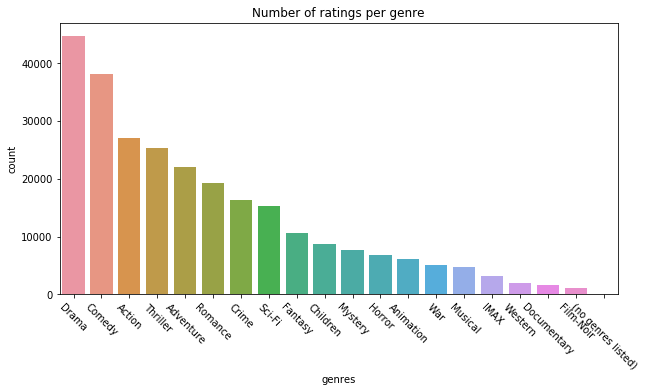

In [594]:
plt.subplots(figsize=(10,5))
sns.countplot(x='genres', order = movies_2['genres'].value_counts().index, data=movies_2);
plt.xticks(rotation=-45)
plt.title('Number of ratings per genre');

# Year Made vs Rating by Genre

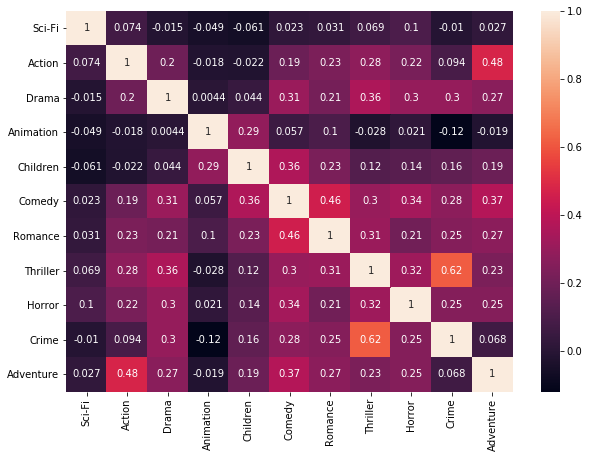

In [553]:
gens = ['Sci-Fi', 'Action', 'Drama', 'Animation', 'Children','Comedy', 'Romance', 
     'Thriller', 'Horror',  'Crime', 'Adventure']

# Year Made vs Rating by Genre
dat = pd.DataFrame()

for g in gens:
    g1 = mean_ratings.loc[g]
    s1 = g1.loc[:]['mean']
    s1 = pd.Series(s1)
    dat = pd.concat([dat,s1], axis=1)
    
dat.columns = gens
datty = dat.fillna(dat.mean())
cory = datty.corr()
plt.subplots(figsize=(10,7))
sns.heatmap(cory, annot=True)

# with fillna (mean)

In [554]:
m_thriller = mdf[ mdf['Thriller'] == 1]
m_crime = mdf[ mdf['Crime'] == 1]
m_tc = mdf[ (mdf['Thriller'] == 1) & (mdf['Crime'] == 1)]

print ('# Thriller: ' + str(len(m_thriller)) )
print ('# Crime: ' + str(len(m_crime)) )
print ('# Thriller/Crime: ' + str(len(m_tc)) )

# Thriller: 25240
# Crime: 16266
# Thriller/Crime: 8825


The heatmap above used fillna() with mean, the one below uses dropna().

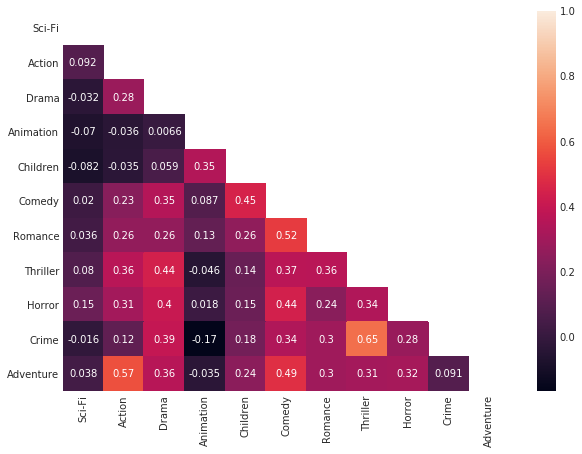

In [555]:
dat.dropna()

dat.columns = gens
cory = dat.corr()
mask = np.zeros_like(cory)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
        plt.subplots(figsize=(10,7))
        sns.heatmap(cory, mask=mask, annot=True);

#With dropna

Standouts with higher correlation Action/Adventure, Thriller/Crime

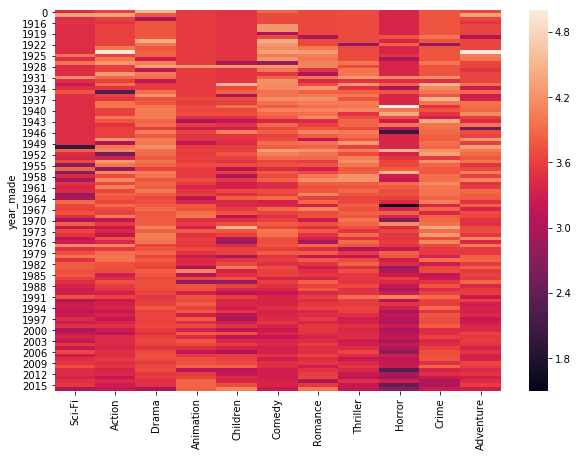

In [508]:
plt.subplots(figsize=(10,7));
ax = sns.heatmap(dat.fillna(dat.mean()));

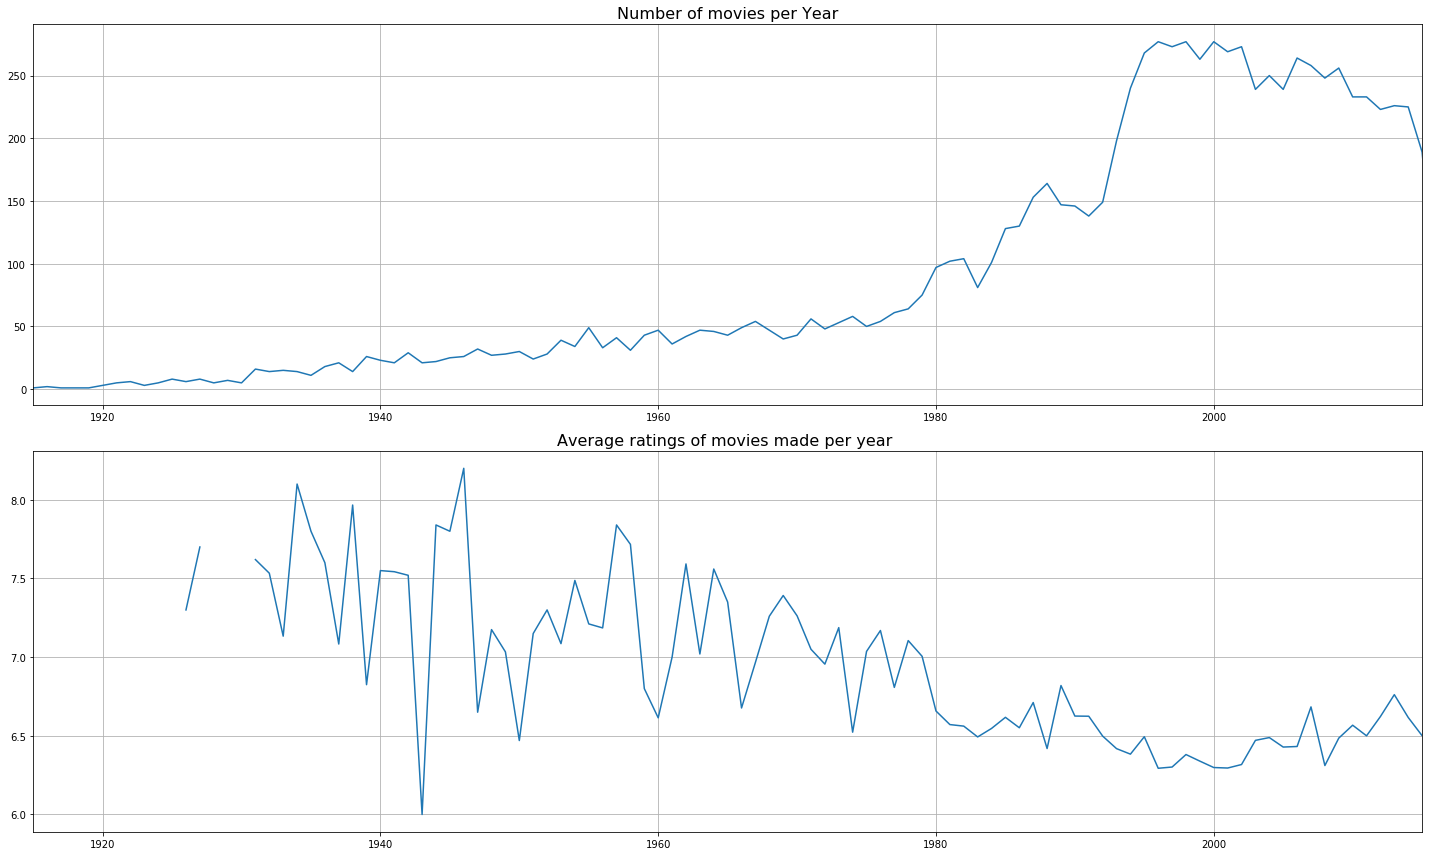

In [556]:
moviedf = movies
moviedf['year']=moviedf['title'].apply(year)
moviedf.title = moviedf.title.str[:-7]

df_xxx = pd.merge(moviedf, dfy, on='title', how='outer')

avg_rates_year2=df_xxx[['year','UserRating']].groupby('year').mean()

fig1, (ax3,ax4) = plt.subplots(2,1,figsize=(20,12))
plt.subplot(211)
plt.plot(df_xxx.groupby(['year']).count()['title'])
plt.title('Number of movies per Year',fontsize=16)
plt.grid(True)
plt.xlim(1915, 2015)

plt.subplot(212)
a2=plt.plot(avg_rates_year2)
plt.title('Average ratings of movies made per year ',fontsize=16)
plt.grid(True)
plt.xlim(1915, 2015)

plt.tight_layout()

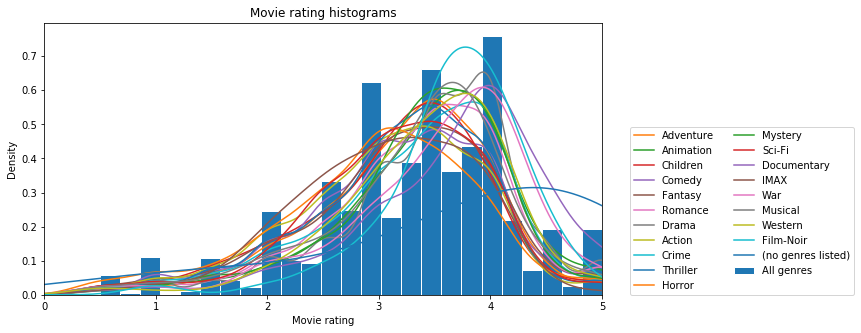

In [560]:
df0 = mdf[['movieId','rating']].groupby('movieId').mean()
df0.hist(bins=25, grid=False, edgecolor='w', normed=True, label ='All genres', figsize=(10,5))

for genre in genres_unique.genre:
    df0 = mdf[mdf[genre]==1]
    df0 = ratings[ratings.set_index('movieId').index.isin(df0.set_index('movieId').index)]
    df0 = df0[['movieId','rating']].groupby('movieId').mean()
    df0.rating.plot(grid=False,  kind='kde', label=genre)
    
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

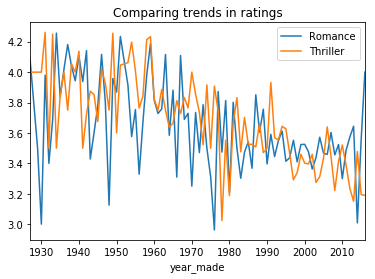

In [512]:
test2 = dat[['Romance', 'Thriller']]

test2 = test2.dropna()
test2.plot();
plt.title('Comparing trends in ratings');

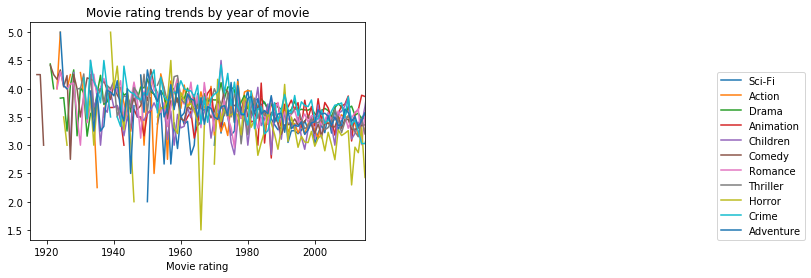

In [595]:
dat.plot()
plt.legend(loc=(2.05,0), ncol=1)
plt.xlim(1915, 2015)
plt.xlabel('Movie rating')
plt.title('Movie rating trends by year of movie')
plt.show()

# Exploring Tags
I'd like to see tags and their corresponding ratings to determine positive and negative tags.

In [456]:
tag_df = pd.read_csv('taggy.csv')
tag_df.columns=('tag', 'rating_mean', 'num_genres', 'num_uses', 'sd_rating')
tag_df2 = tag_df.loc[2:,:]

n1 = pd.to_numeric(tag_df2['rating_mean'])
n2 = pd.to_numeric(tag_df2['num_genres'])
n3 = pd.to_numeric(tag_df2['sd_rating'])
n4 = pd.to_numeric(tag_df2['num_uses'])

dd = pd.DataFrame()
dd = pd.concat([dd, tag_df['tag']])
dd = pd.concat([dd, n1], axis=1)
dd = pd.concat([dd, n2], axis=1)
dd = pd.concat([dd, n3], axis=1)
dd = pd.concat([dd, n4], axis=1)

dd.columns=('tag', 'rating_mean', 'num_genres', 'sd_rating', 'num_uses')
dd = dd.loc[2:,:]
dd.head()

,tag,rating_mean,num_genres,sd_rating,num_uses
2,aliens,2.764706,17.0,1.961486,17.0
3,sci-fi,3.432432,37.0,1.882530,37.0
4,action,3.250000,12.0,1.790124,12.0
5,space,3.538462,13.0,1.761410,13.0
6,dark,4.142857,14.0,1.598420,14.0


# Positive tags
 
Here I sorted the tags by mean rating to get a feel for tags at polar ends of the spectrum.


In [457]:
p1 = dd.sort_values('rating_mean', ascending=False)
del p1['num_genres']
p1.head(10)

,tag,rating_mean,sd_rating,num_uses
53,Christopher Nolan,5.000000,0.000000,13.0
52,Pixar,5.000000,0.000000,17.0
51,psychology,5.000000,0.000000,14.0
50,nonlinear,5.000000,0.000000,11.0
49,twist ending,4.973684,0.113147,38.0
46,philosophy,4.850000,0.241523,10.0
45,imaginative,4.818182,0.252262,11.0
35,Quentin Tarantino,4.812500,0.403113,16.0
31,dark comedy,4.809524,0.460331,21.0
30,coming of age,4.700000,0.483046,10.0


# Negative tags
boring, long, bad plot, overrated are all tags you shouldn't be surprised to see, although I did not expect Brad Pitt.

In [458]:
p2 = p1.sort_values('rating_mean', ascending=True)
p2.head(10)

,tag,rating_mean,sd_rating,num_uses
21,boring,1.466667,0.639940,15.0
11,long,1.818182,1.167748,11.0
23,bad plot,2.590909,0.625227,11.0
26,overrated,2.684211,0.558035,19.0
2,aliens,2.764706,1.961486,17.0
4,action,3.250000,1.790124,12.0
3,sci-fi,3.432432,1.882530,37.0
5,space,3.538462,1.761410,13.0
12,anime,3.638889,1.079756,36.0
15,Brad Pitt,3.684211,0.711230,19.0


# Exploring Users
To gain better insight into how individual user ratings varied, I found the top/bottom users by avg rating and by standard deviation.

In [561]:
import re

def year(title):
    year=re.search(r'\(\d{4}\)', title)
    if year:
        year=year.group()
        return int(year[1:5])
    else:
        return 0

mdf['year']=mdf['title'].apply(year)
mdf.title = mdf.title.str[:-7]

md1 = imdb_dat.merge(mdf, left_on='Name', right_on='title', how='inner')
collab =  imdb_usd.merge(mdf, left_on='Name', right_on='title', how='inner')

In [460]:
rp = pd.read_csv('ratings_exp.csv')
rpiv2 = rp.groupby('userId').agg({'rating': [np.size, np.mean, np.std]})
#atleast_10rs = rpiv['rating']['size'] >= 100
grumpy = rpiv2.sort_values([('rating', 'mean')], ascending=True)[:20]
happy = rpiv2.sort_values([('rating', 'mean')], ascending=False)[:20]

variant = rpiv2.sort_values([('rating', 'std')], ascending=False)[:20]
notvariant = rpiv2.sort_values([('rating', 'std')], ascending=True)[:20]

To get a feel for different user habits I grouped users into the following groups.

Grumpy<br>

userId | size	| mean |	std
--- | --- | --- | ---
579	| 35.0 |1.228571	| 1.268063
581	|67.0| 1.552239	|1.542662
207	|76.0	|2.111842	|1.729352
133	|212.0|	2.216981	|1.378609
609|	128.0	|2.265625	|1.837854


Happy<br>

userId |	size	|mean|	std
--- | --- | --- | ---	
46	|60.0|	4.950000|	0.199576
443	|82.0|	4.853659|	0.319024
298	|143.0|	4.842657|	0.421348
448	|39.0|	4.717949|	0.686284
454	|43.0|	4.662791|	0.614516

High Variance rating users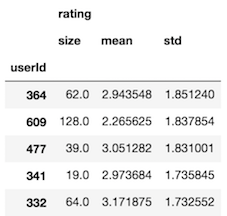
Low Variance rating users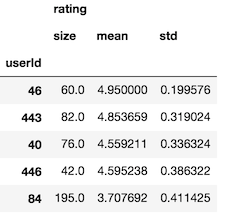

# Links / Scraping
I wanted to scrape the websites for duration and budget data and use that in comparisons.

In [461]:
#clean up
dfim = imdb_usd
del dfim['Unnamed: 0']
dfim.head()
dfim.shape

del mdf['timestamp']
del mdf['(no genres listed)']

In [462]:
mdf2 = mdf.groupby('title').agg({'rating': [np.size, np.mean]})

dfz = dfim[['Name', 'Budget', 'Runtime', 'CR', 'UserRating']]
dfy=dfz.rename(columns = {'Name':'title'})
dfy.head()

,title,Budget,Runtime,CR,UserRating
0,Toy Story,30000000,81.0,All_Ages,8.3
1,Jumanji,50000000,104.0,PG,6.9
2,Grumpier Old Men,25000000,101.0,NFY,6.6
3,Waiting to Exhale,16000000,124.0,Restr1,5.7
4,Father of the Bride Part II,30000000,106.0,PG,6.0


explode method to create a seperate row for each genre of a title from: <br>
https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

In [464]:
df_xy = df_xxx[df_xxx['genres'].notnull()]

genre_iter = (set(x.split('|')) for x in df_xy.genres)
genres = sorted(set.union(*genre_iter))

def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

df_xy.loc[:,'genres'] = df_xy.genres.str.split('|')
df_xy = explode(df_xy, ['genres'])
df_xy.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,movieId,title,genres,year,Budget,Runtime,CR,UserRating
0,1.0,Toy Story,Adventure,1995.0,30000000.0,81.0,All_Ages,8.3
1,1.0,Toy Story,Animation,1995.0,30000000.0,81.0,All_Ages,8.3
2,1.0,Toy Story,Children,1995.0,30000000.0,81.0,All_Ages,8.3
3,1.0,Toy Story,Comedy,1995.0,30000000.0,81.0,All_Ages,8.3
4,1.0,Toy Story,Fantasy,1995.0,30000000.0,81.0,All_Ages,8.3


In [513]:
df_x2 = df_xxx[['title', 'UserRating','genres', 'Budget', 'year', 'Runtime']]
df_x2.dropna()

df_x3 = df_x2[ ~df_x2['genres'].isnull()]

testdf = pd.concat([df_x3.drop('genres', axis=1), df_x3.genres.str.get_dummies(sep='|')], axis=1) 

print ('# UserRating NaNs', testdf['UserRating'].isnull().sum())
print ('# Runtime NaNs', testdf['Runtime'].isnull().sum())

userrats = testdf[ ~testdf['UserRating'].isnull() ]

# UserRating NaNs 5781
# Runtime NaNs 5781


# Genre, Runtime, Budget and Ratings

Boxplots:
1. Budget - by UserRating
2. Runtime - by UserRating

It looks like low rated movies usually have a low budget.

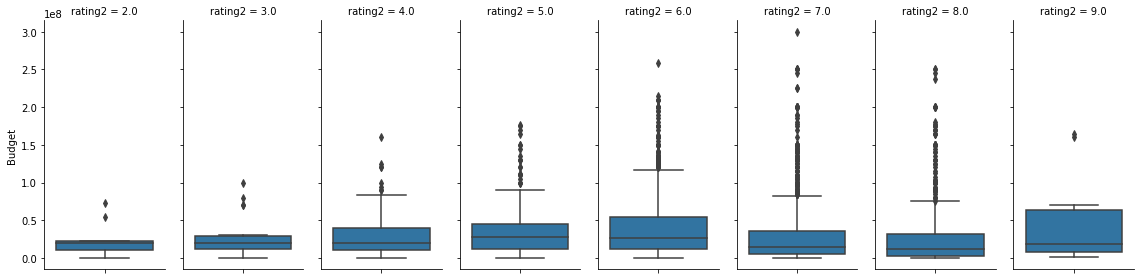

In [488]:
# 1 . Budget - by UserRating
testdf['rating2'] = testdf['UserRating'].round()

sns.factorplot( y="Budget",
               col="rating2", col_wrap=8, data=testdf, kind="box", size=4, aspect=.5);

Movies rated 9.0 tend to be longer than the rest.

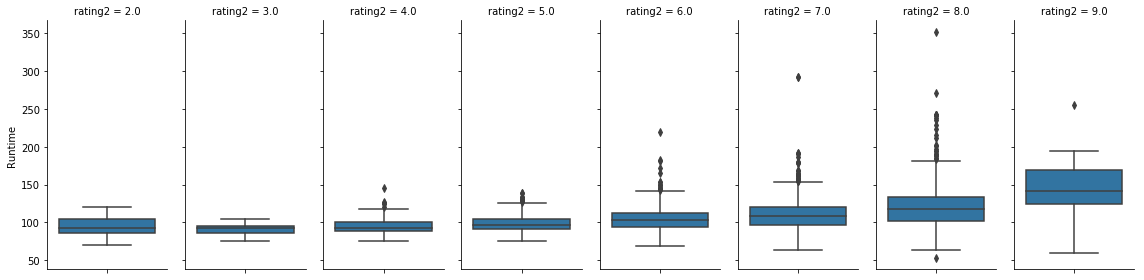

In [494]:
# 2 . Runtime - by UserRating
sns.factorplot( y="Runtime",
               col="rating2", col_wrap=8, data=testdf, kind="box", size=4, aspect=.5);

Box Plots:
3. UserRating - by Genre
4. Budget - by Genre 

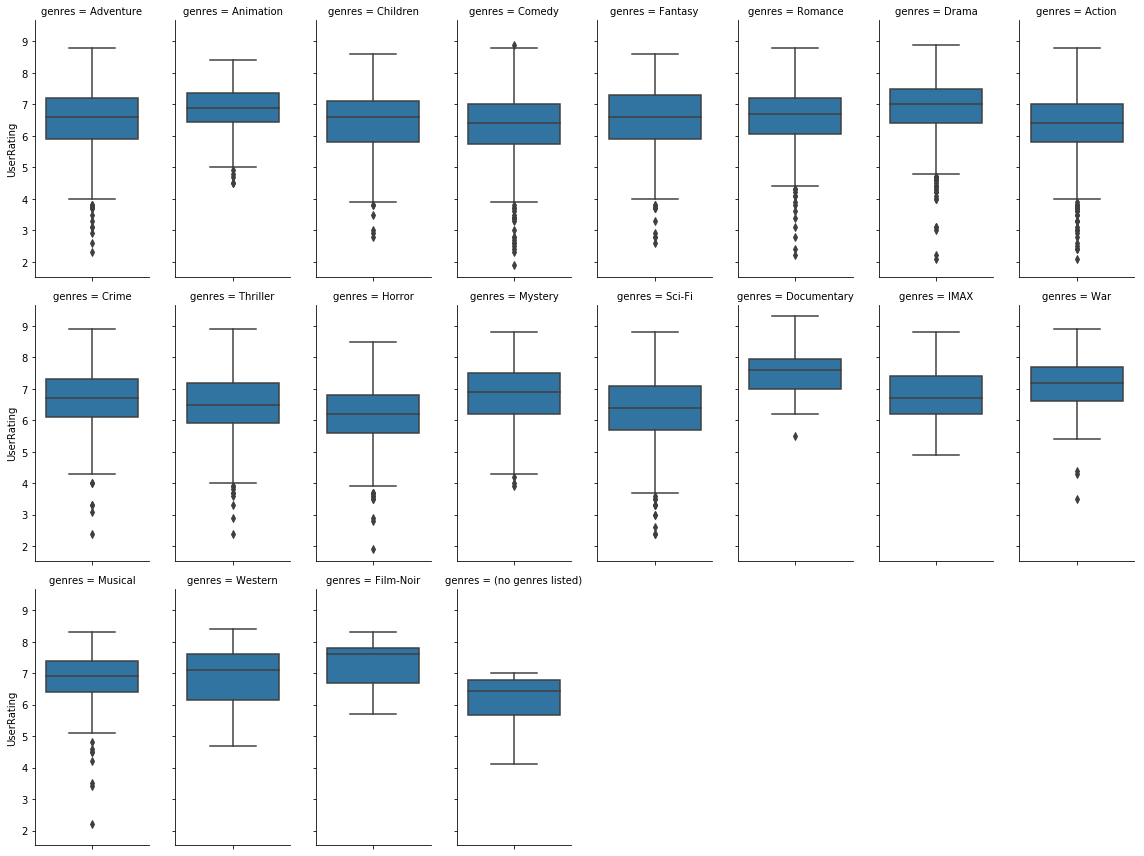

In [491]:
# 3 . UserRating - by Genre
sns.factorplot( y="UserRating",
               col="genres", col_wrap=8, data=df_xy, kind="box", size=4, aspect=.5);

Cheapest genres: Comedy, Documentary, Drama <br>
Most expensive: Animation, IMAX

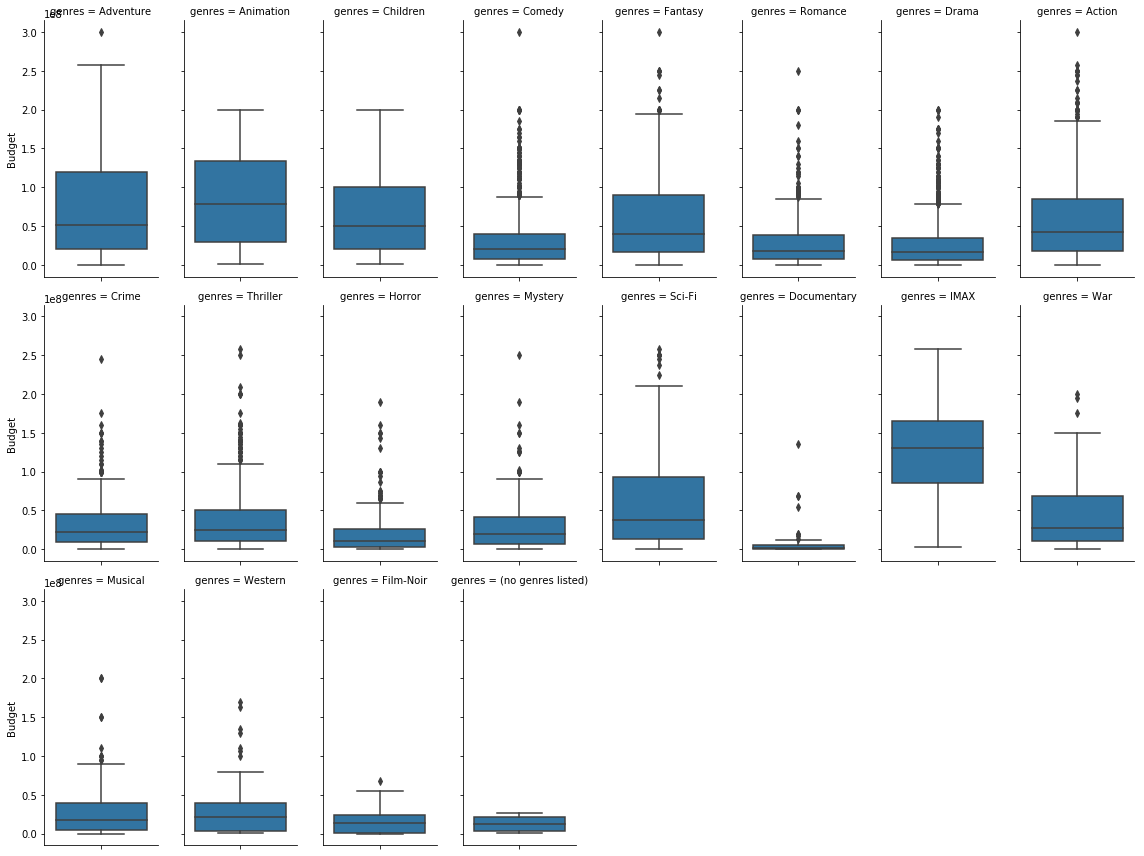

In [469]:
# 4 . Budget - by Genre
df_xy['rating2'] = df_xy['UserRating'].round()

sns.factorplot( y="Budget",
               col="genres", col_wrap=8,data=df_xy, kind="box", size=4, aspect=.5);

To make things more workable, I divided content ratings into 5 groups with reference to MPAA standards, https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system<br>

<br>
'All_Ages' : 'G', <br>
"Parental_Guidance": ['PG', 'AA', 'PA'], <br>
"Not_for_younger": ['PG-13', '13+', '14', '14+'], <br>
"Restricted_1": ['14A', '18A'], <br>
"Restricted_2": ['R', 'A', '18+', '16+', '(BANNED)', '18', 'M'] <br>
<br>
Box plots below:
5. Budget - by ContentRating
6. UserRating - by ContentRating

It appears as though if a movie is destined for a larger audience it has a larger budget.

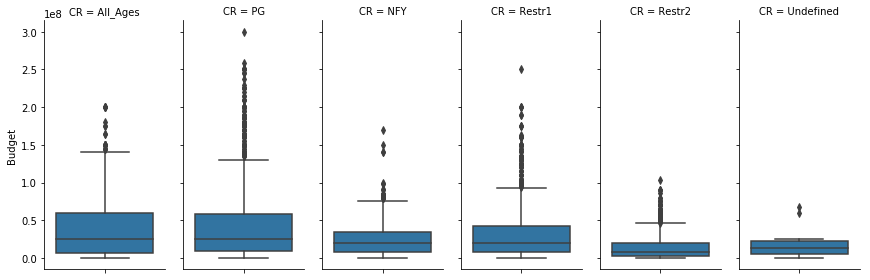

In [567]:
# 5 . Budget - by ContentRating
sns.factorplot( y="Budget",
               col="CR", col_wrap=8, data=dfy, kind="box", size=4, aspect=.5);

#highly restrictive films are usually not blockbusters

(4, 9)

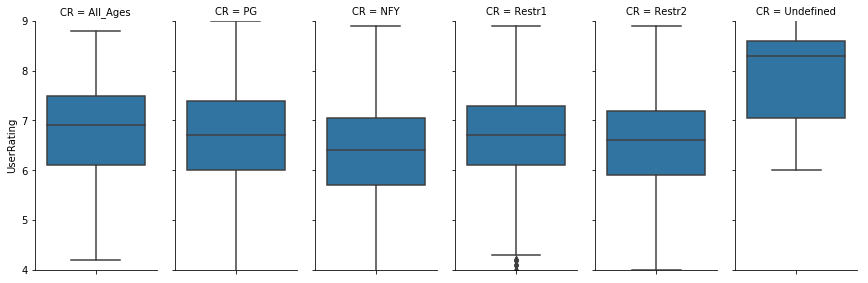

In [562]:
# 6 . UserRating - by ContentRating
sns.factorplot( y="UserRating",
               col="CR", col_wrap=8, data=dfy, kind="box", size=4, aspect=.5);
plt.ylim(4,9)
#not much to see here

# Pairplot

In an attempt to spot any patterns I pairplotted Budget, Runtime, UserRating, and Year Made 

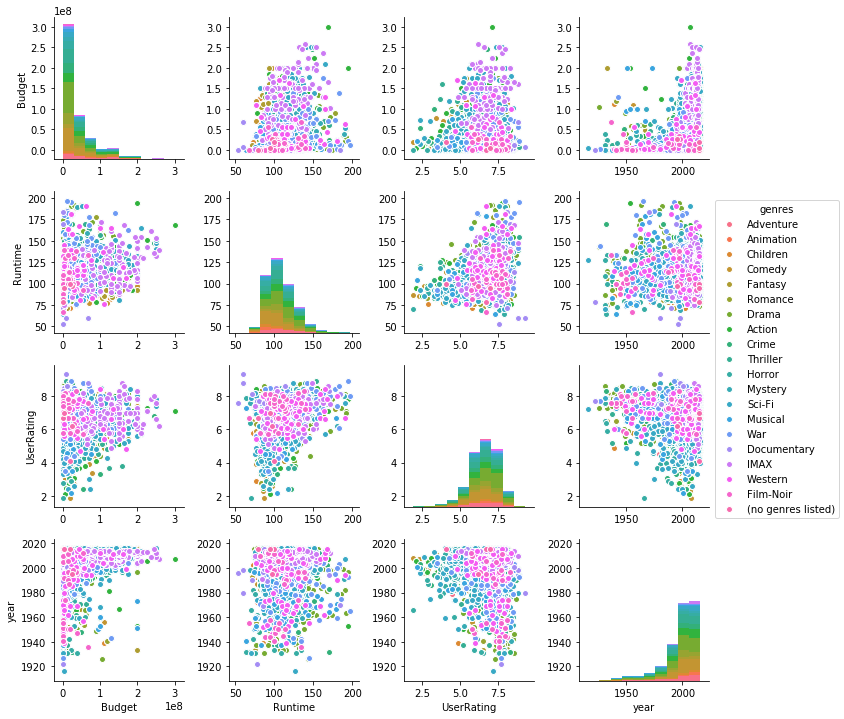

In [495]:
df_xtest = df_xy[['Budget', 'Runtime', 'UserRating', 'year', 'genres']]
df_xtest2 = df_xtest.dropna()
df_xtest22 = df_xtest2[ (df_xtest2['Runtime'] <= 200) & (df_xtest2['Budget'] > 1)]
sns.pairplot(df_xtest22, hue='genres');

Hard to see anything with so many genres/colours, let's trim them down a bit:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


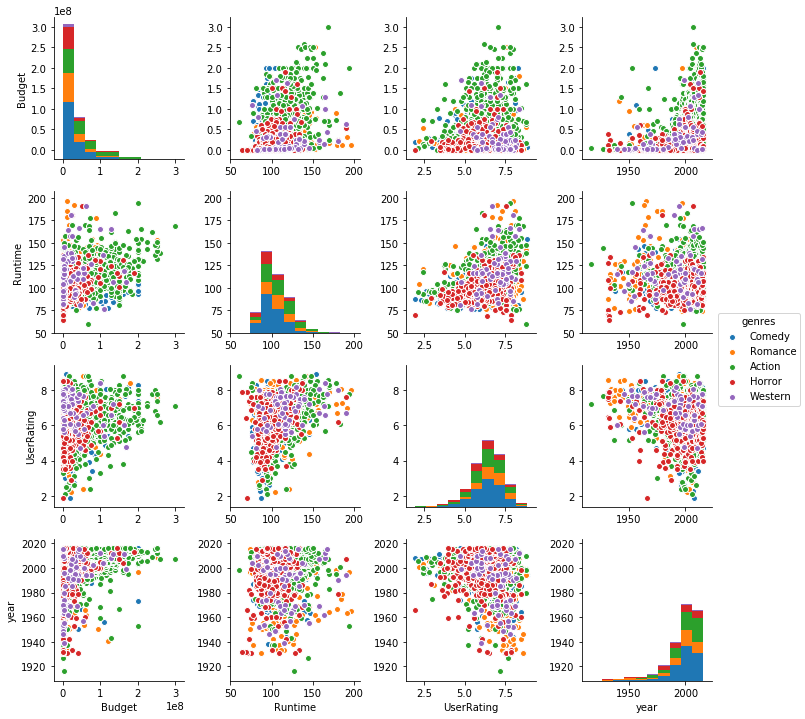

In [592]:
dfgen = df_xtest[ (df_xtest['genres'] == 'Action') | (df_xtest['genres'] == 'Horror') |
                 (df_xtest['genres'] == 'Romance') |  (df_xtest['genres'] == 'Comedy') |  
                 (df_xtest['genres'] == 'Western')]

df_gen = dfgen[['Budget', 'Runtime', 'UserRating', 'year', 'genres']]
df_g = df_gen.dropna()
df_g = df_g[ (df_g['Runtime'] <= 200) & (df_g['Runtime'] >= 60) & (df_xtest2['Budget'] > 10000)]
sns.pairplot(df_g, hue='genres');

In [499]:
df_x4= df_xxx[['movieId', 'UserRating','genres', 'Budget', 'year', 'Runtime']]
df_x5 = df_x4[ ~df_x4['genres'].isnull()]
testdf6 = pd.concat([df_x5.drop('genres', axis=1), df_x5.genres.str.get_dummies(sep='|')], axis=1)  

In [576]:
df_xtest22.head()

,Budget,Runtime,UserRating,year,genres
0,30000000.0,81.0,8.3,1995.0,Adventure
1,30000000.0,81.0,8.3,1995.0,Animation
2,30000000.0,81.0,8.3,1995.0,Children
3,30000000.0,81.0,8.3,1995.0,Comedy
4,30000000.0,81.0,8.3,1995.0,Fantasy


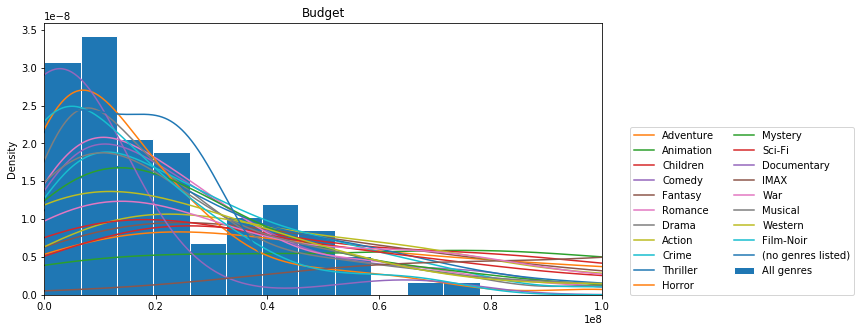

In [648]:
testdf6 = testdf6.dropna()

df6 = testdf6[['year','Budget']].groupby('year').mean()
df6.hist(bins=20, grid=False, edgecolor='w', normed=True, label ='All genres', figsize=(10,5))


for genre in genres_unique.genre:
    dft = testdf6[testdf6[genre]==1]
    dft = testdf6[testdf6.set_index('movieId').index.isin(dft.set_index('movieId').index)]
    dft = dft[['movieId','Budget']].groupby('movieId').mean()
    dft.Budget.plot(grid=False, kind='kde', label=genre);
    
    
plt.xlim(0,100000000)
plt.legend(loc=(1.05,0), ncol=2);

Looking for correlation between Budget and Runtime

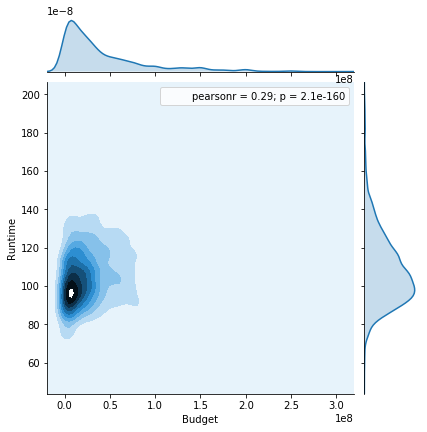

In [557]:
sns.jointplot( x='Budget', y='Runtime', data=df_xtest22, kind='kde');

Budget vs Runtime (Animation)

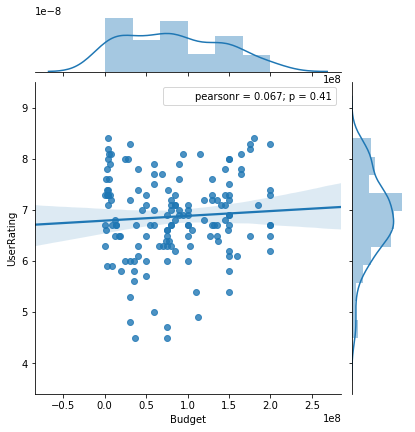

In [586]:
anim_mov = df_xtest22[ df_xtest22['genres']=='Animation']
hor_mov = df_xtest22[ df_xtest22['genres']=='Horror']

sns.jointplot( x='Budget', y='UserRating', data=anim_mov, kind='reg');

Budget vs Runtime (Horror Movies)

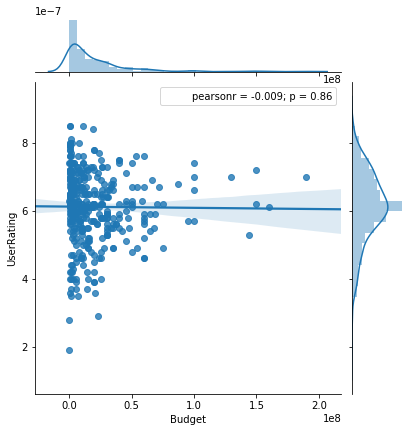

In [585]:
sns.jointplot( x='Budget', y='UserRating', data=hor_mov, kind='reg');

Animation movies seemed to have a higher corrrelation than Horror

Rating distribution per genre overview

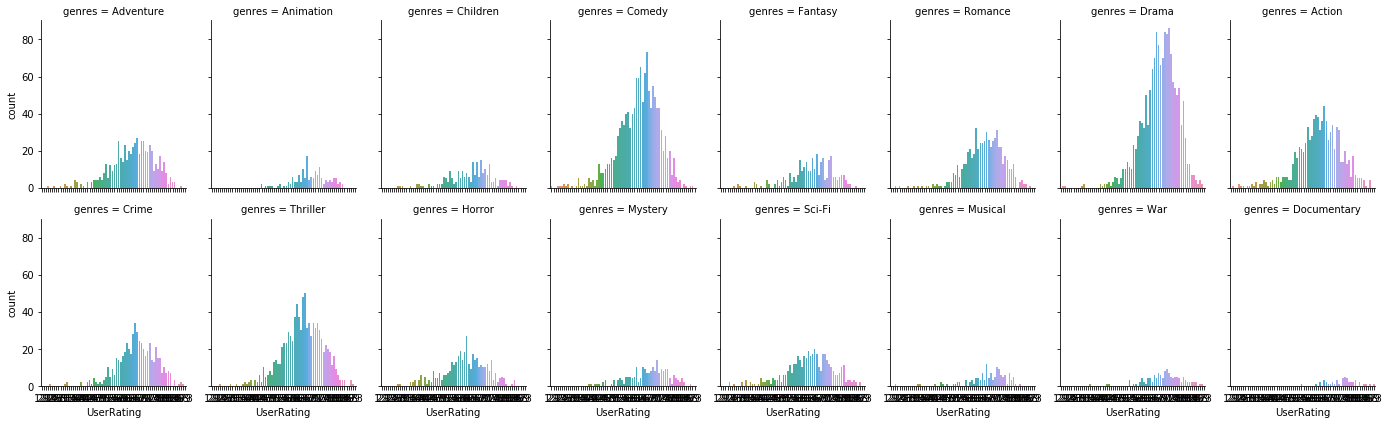

In [579]:
tempdat = df_xtest22[ (df_xtest22['genres'] != 'IMAX') & (df_xtest22['genres'] != 'Western') &
                    (df_xtest22['genres'] != 'Film-Noir') & (df_xtest22['genres'] != '(no genres listed)')]
g = sns.factorplot('UserRating', col="genres", col_wrap=8,
                   data=tempdat,                   
                   kind="count", size=3, aspect=.8)

In [613]:
movies.genres = movies.genres.str.split('|')
movies = explode(movies, ['genres'])
mmm = movies.merge(ratings, on='movieId')
mmm = mmm [ ~ (mmm['genres'] == '(no genres listed)')]

There are 671 unique userIds in the ratings file.  671 have rated an Action movie, 258 have rated a Documentary.